In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from simtk import unit
from simtk import openmm as omm
from simtk.openmm import app
import molsysmt as msm
from tqdm import tqdm

# Alanine dipeptide in vacuum

## With OpenMM from scratch

In [3]:
from molecular_systems import files
pdbfile_path = files.alanine_dipeptide['vacuum.pdb']
view = msm.view(pdbfile_path, standardize=False)
view

NGLWidget()

In [9]:
temperature = 300.0*unit.kelvin
collisions_rate = 1.0/unit.picoseconds
total_time = 2.0*unit.nanoseconds
saving_timestep = 1.0*unit.picoseconds
integration_timestep = 2.0*unit.femtoseconds

steps_per_cicle = round(saving_timestep/integration_timestep)
n_steps = round(total_time/integration_timestep)
n_cicles = round(n_steps/steps_per_cicle)

pdbfile = app.PDBFile(pdbfile_path)

topology = pdbfile.topology
positions = pdbfile.positions

forcefield = app.ForceField('amber/protein.ff14SB.xml')

system = forcefield.createSystem(topology, nonbondedMethod=app.NoCutoff, constraints=app.HBonds)

integrator = omm.LangevinIntegrator(temperature, collisions_rate, integration_timestep)
integrator.setConstraintTolerance(0.00001)

platform = omm.Platform.getPlatformByName('CUDA')
simulation_properties = {}
simulation_properties['CudaPrecision']='mixed'

# Context.

context = omm.Context(system, integrator, platform, simulation_properties)
context.setPositions(positions)

# Energy Minimization
omm.LocalEnergyMinimizer_minimize(context)

# Initial velocities
n_atoms = topology.getNumAtoms()
velocities = np.zeros([n_atoms, 3], np.float32) * unit.nanometers/unit.picosecond
context.setVelocities(velocities)

# Reporter arrays: time, position, velocity, kinetic_energy, potential_energy

time = np.zeros([n_cicles], np.float32) * unit.picoseconds
trajectory = np.zeros([n_cicles, n_atoms, 3], np.float32) * unit.nanometers
velocity = np.zeros([n_cicles, n_atoms, 3], np.float32) * unit.nanometers/unit.picosecond
kinetic_energy = np.zeros([n_cicles], np.float32) * unit.kilocalories_per_mole
potential_energy = np.zeros([n_cicles], np.float32) * unit.kilocalories_per_mole

# Initial context in reporters

state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
time[0] = state.getTime()
trajectory[0] = state.getPositions()
velocity[0] = state.getVelocities()
kinetic_energy[0] = state.getKineticEnergy()
potential_energy[0] = state.getPotentialEnergy()

# Integration loop saving every cicle steps

for ii in tqdm(range(1, n_cicles)):
    context.getIntegrator().step(steps_per_cicle)
    state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
    time[ii] = state.getTime()
    trajectory[ii] = state.getPositions()
    velocity[ii] = state.getVelocities()
    kinetic_energy[ii] = state.getKineticEnergy()
    potential_energy[ii] = state.getPotentialEnergy()

100%|██████████| 1999/1999 [01:06<00:00, 30.07it/s]


In [5]:
msm.view([topology, trajectory])

NGLWidget(max_frame=999)

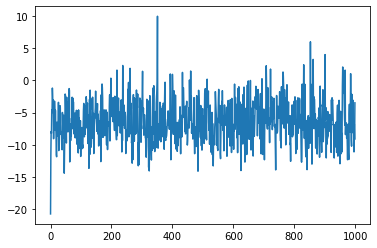

In [6]:
plt.plot(time, potential_energy)
plt.show()

In [7]:
phi_chains, psi_chains, phi_values, psi_values = msm.ramachandran_angles([topology, trajectory])

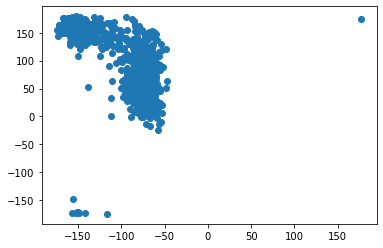

In [8]:
plt.scatter(phi_values, psi_values)

## With MolSysMT 

## With this library

In [12]:
from molecular_systems import AlanineDipeptideVacuum
from molecular_systems.tools.md import langevin_NVT

In [18]:
dialanine=AlanineDipeptideVacuum(forcefield='AMBER96')

time, trajectory, velocity, kin_energy, pot_energy = langevin_NVT (dialanine,
                                                                   temperature = 300 * unit.kelvin,
                                                                   friction = 1.0 / unit.picoseconds,
                                                                   initial_positions = dialanine.coordinates,
                                                                   integration_timestep = 2 * unit.femtoseconds,
                                                                   saving_timestep = 1.0 * unit.picoseconds,
                                                                   total_time = 2.0 * unit.nanoseconds)

100%|██████████| 1999/1999 [00:56<00:00, 35.56it/s]


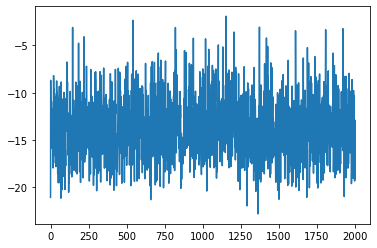

In [19]:
plt.plot(time, pot_energy)
plt.show()

In [20]:
_, _, phi_values, psi_values = msm.ramachandran_angles([dialanine.topology, trajectory])

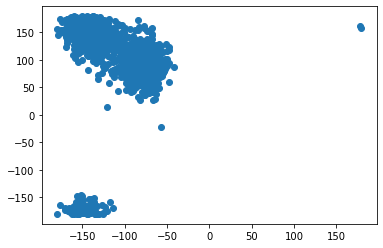

In [21]:
plt.scatter(phi_values, psi_values)

## With OpenExplorer